# Analysis Framework

### Data cleaning
 1. filter out non-Eng reviews (using spacy language detector)
 2. sentence segmentation (will need to assess the implication of this, may bot be helpful at all)

 ### Pre-processing
 1. strip white space and line breaks
 2. remove stop words, punc
 3. lemmatization
 4. lowercase
 5. noun / noun phrase extraction (will need to assess the implication of this, may bot be helpful at all)

### Data transformation
 1. TfidfVectorizer
  1. n_gram range: [(1,1), (1,2), (2,2)]
  2. max_df: 0.9
  3. min_df: [5, 10, 15, 20]
  
  
 2. CountVectorizer
  1. n_gram range: [(1,1), (1,2), (2,2)]

### Model Selection and evaluation
 
 1. Sickit Learn
  1. LDA (perplexity socre, log-likelihood, human judgement) 
  2. NMF (human judgement)
  
1. Gensim
  1. LDA (coherence measure)
  2. NMF (human judgement)

### Visualization
1. multi-bar chart to explore weights of different terms in each topic
2. PyLDAVis

# Import libraries

In [1]:
import pandas as pd
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
import pickle

# Import reviews

In [2]:
with open('sg_reviews.pkl', 'rb') as f:
    sg_reviews = pickle.load(f)
    
with open('au_reviews.pkl', 'rb') as f:
    au_reviews = pickle.load(f)

# Pre-processing

In [ ]:
# Only run this once, or you need to restart the kernel to avoid errors
Language.factory("language_detector", func=get_lang_detector)

In [4]:
# language detection function
def get_lang_detector(nlp, name):
    return LanguageDetector()

#init the nlp function and add language detector to the pipeline
nlp = spacy.load("en_core_web_trf")

nlp.add_pipe('language_detector', last=True)

print(nlp.pipe_names)

def lan_detect(x):
    text=str(x)
    with nlp.select_pipes(enable=['parser', 'language_detector']):    
        doc = nlp(text)
        lan_score=doc._.language
    return lan_score['language'], lan_score['score']

['transformer', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'language_detector']


In [10]:
trial=sg_reviews.sample(5000)

In [11]:
trial['language'], trial['cof_score'] = zip(*trial['review'].map(lan_detect))

In [12]:
trial_en=trial[trial['language']=='en']

# sg_reviews_en['review_explode']=sg_reviews_en['review'].apply(lambda x:sent_tokenize(x))
# sg_reviews_en=sg_reviews_en.explode('review_explode')

# SKlearn - vectorization

In [13]:
stop_words=spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    # remove line breaks
    stripped_sentence = re.sub('\n', '', sentence)
    
    # parse sentence using spacy nlp pipeline
    with nlp.select_pipes(enable=['transformer', 'tagger', 'attribute_ruler', 'lemmatizer']):
        tokens=nlp(stripped_sentence)
     
    # lemmetize and remove punctuation
    lemma_tokens=[token.lemma_.lower().strip() for token in tokens if not token.is_punct]
    
    # removing stop words
    lemma_tokens_no_stop_words=[word for word in lemma_tokens if word not in stop_words]
      
    return lemma_tokens_no_stop_words

In [ ]:
# func test
spacy_tokenizer('Used to be a good app been using for years, now pools orders sending poor drivers in circles and baiting customers with artificial delivery time.')

In [16]:
# split the sample for train and test
X_train, X_test=train_test_split(trial_en.review, test_size=0.2, random_state=100)

In [17]:
#init vectorizer with different settings

tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,2), 
                                   lowercase=True,
                                   min_df=5, 
                                   stop_words='english')

tfidf_vectorizer_spacy = TfidfVectorizer(ngram_range = (1,2),min_df=5, tokenizer=spacy_tokenizer)

count_vectorizer = CountVectorizer(ngram_range = (1,2), 
                                   lowercase=True,
                                   min_df=5, 
                                   stop_words='english')

count_vectorizer_spacy = CountVectorizer(ngram_range = (1,2),min_df=5, tokenizer=spacy_tokenizer)

# Sickit-learn

In [ ]:
%%time
tfidf_documents = tfidf_vectorizer_spacy.fit_transform(apple_reviews['review'])
tfidf_feature_names = tfidf_vectorizer_spacy.get_feature_names()


In [18]:
%%time
tfidf_documents_std = tfidf_vectorizer.fit_transform(X_train)
tfidf_feature_names_std = tfidf_vectorizer.get_feature_names()
vectorized_data=tfidf_vectorizer.transform(X_test)

Wall time: 50 ms


In [19]:
tf_documents_std=count_vectorizer.fit_transform(X_train)
tf_feature_names_std = count_vectorizer.get_feature_names()
vectorized_data_tf=count_vectorizer.transform(X_test)

In [49]:
n_topics = 5

from sklearn.decomposition import LatentDirichletAllocation

# This will take a couple of minutes to run...

lda = LatentDirichletAllocation(n_components = n_topics,
                                learning_method='online',
                                random_state=100,          # Random state
                                batch_size=128,            # n docs in each learning iter
                                evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                n_jobs = -1)
lda.fit(tfidf_documents_std)
topic_models = lda.components_

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Higher the better
print("Log Likelihood: ", lda.score(vectorized_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(vectorized_data))

# See model parameters
print(lda.get_params())

Log Likelihood:  -9151.84317563333
Perplexity:  2143.793391193669
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


# GridSearch

In [25]:
from sklearn.model_selection import GridSearchCV
search_params = {'n_components': [2,3,4,5], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation(n_jobs = -1)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(tfidf_documents_std)

GridSearchCV(estimator=LatentDirichletAllocation(n_jobs=-1),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5]})

In [26]:
best_model=model.best_estimator_
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_model.perplexity(vectorized_data))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -7370.6294356406
Model Perplexity:  1327.8045184710647


In [63]:
num_top_words = 8
tf_feature_names=tfidf_vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        print("topic %d:" % (topic_idx), term_list)


display_topics(lda, tf_feature_names, num_top_words)

topic 0: ['nice', 'food', 'best', 'app', 'bad', 'awesome', 'grab', 'useful']
topic 1: ['good', 'great', 'easy', 'app', 'use', 'service', 'good service', 'good app']
topic 2: ['food', 'panda', 'helpful', 'food panda', 'delivery', 'app', 'like', 'services']
topic 3: ['order', 'time', 'app', 'service', 'don', 'just', 'customer', 'food']
topic 4: ['fast', 'amazing', 'great', 'loved', 'great service', 'service', 'improve', 'fast delivery']


c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


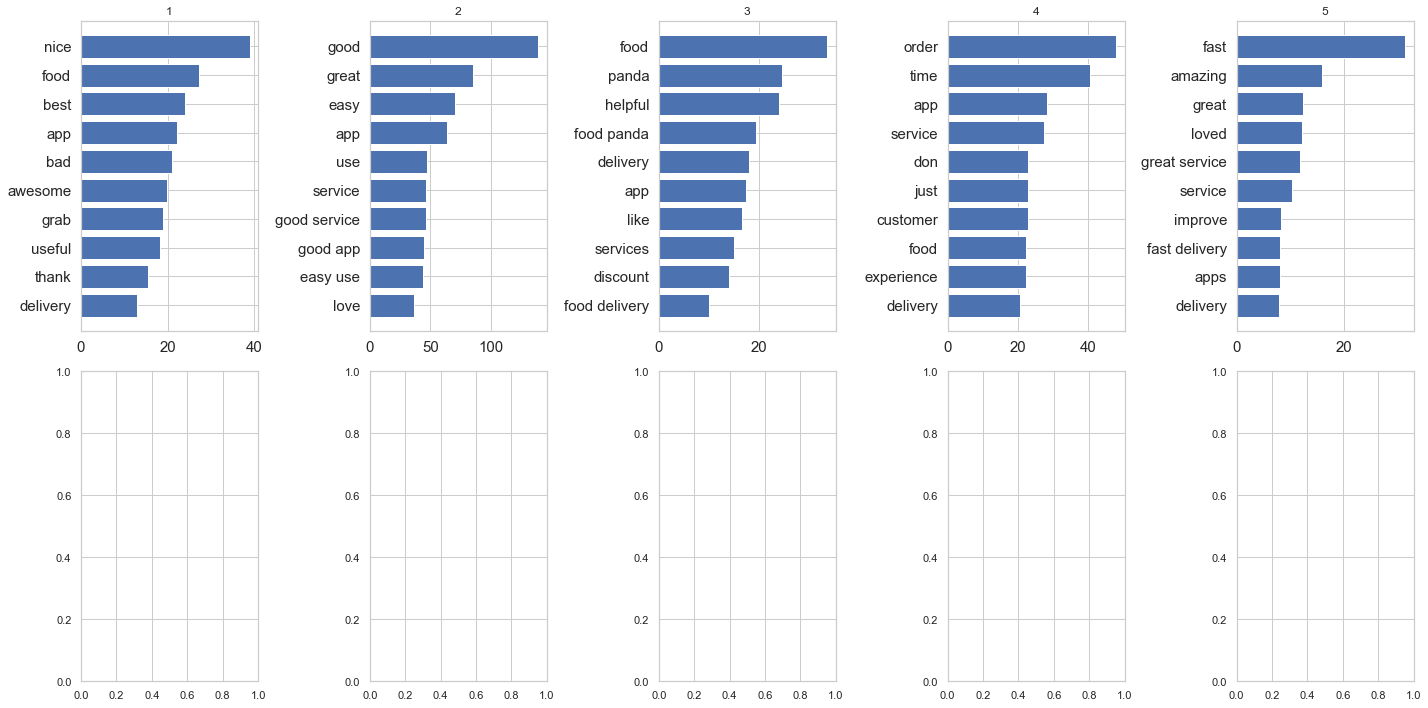

In [50]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 5)
sns.set(style="whitegrid")

for n, topic in enumerate(lda.components_):
    top10_index=topic.argsort()[-10:]
    y=[tf_feature_names[i] for i in top10_index]
    x=topic[top10_index]
    if n>4:
        axs[1, n-5].barh(y, x)
        axs[1, n-5].set_title(n+1)
        axs[1, n-5].tick_params(axis='both', which='major', labelsize=15)
    else:
        axs[0, n].barh(y, x)
        axs[0, n].set_title(n+1)
        axs[0, n].tick_params(axis='both', which='major', labelsize=15)

    n=n+1
fig.set_figheight(10)
fig.set_figwidth(20)
fig.tight_layout()
    
    
    

In [52]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, tfidf_documents_std, tfidf_vectorizer)

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.073265  0.096491       1        1  38.782695
1     -0.282004 -0.056884       2        1  18.808965
0      0.151362  0.024367       3        1  18.469993
2      0.101945 -0.202372       4        1  13.450094
4     -0.044569  0.138399       5        1  10.488253, topic_info=             Term        Freq       Total Category  logprob  loglift
300          good  123.000000  123.000000  Default  30.0000  30.0000
317         great   82.000000   82.000000  Default  29.0000  29.0000
224          easy   57.000000   57.000000  Default  28.0000  28.0000
257          fast   34.000000   34.000000  Default  27.0000  27.0000
308  good service   38.000000   38.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
607       service   10.917511   81.765828   Topic5  -3.8612   0.2414
176      delivery    8.426099   58.026482   Topic5  -4.1202   0.3253
34            app    7.614596  118.771404   Topic5  -4.2215  -0.4922
15        account    4.068490   11.920183   Topic5  -4.8483   1.1800
137    convenient    3.706168   16.955189   Topic5  -4.9416   0.7343

[263 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
10        4  0.858905       50
14        2  0.809804   access
15        1  0.335565  account
15        3  0.251674  account
15        5  0.335565  account
...     ...       ...      ...
757       3  0.793944    world
759       1  0.840770    worst
759       2  0.129349    worst
765       1  0.782702    wrong
765       3  0.142309    wrong

[311 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

# NMF

In [53]:


from sklearn import decomposition

nmf = decomposition.NMF(n_components=5, init="nndsvd")
W = nmf.fit_transform(tfidf_documents_std) 
H = nmf.components_

top = 8
topic_index_max = 5

for topic_index in range(0, topic_index_max):
    top_indices = np.argsort(H[topic_index, :])[::-1]
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append(tfidf_feature_names_std[term_index])
    print("topic ", topic_index, top_terms)

topic  0 ['good', 'good app', 'good apps', 'apps', 'good experience', 'good service', 'experience', 'food good']
topic  1 ['great', 'great app', 'great service', 'app great', 'app', 'work', 'options', 'services']
topic  2 ['easy', 'easy use', 'use', 'use app', 'fast', 'helpful', 'convenient', 'easy order']
topic  3 ['service', 'good service', 'good', 'great service', 'customer', 'customer service', 'bad', 'worst']
topic  4 ['app', 'food', 'good app', 'order', 'love', 'delivery', 'time', 'nice']


c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


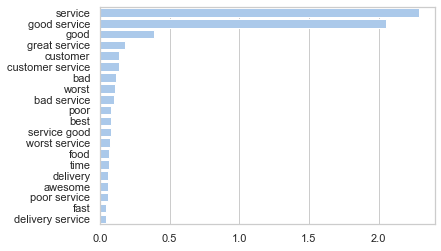

In [66]:
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="whitegrid")

topic_index = 3
vocab = np.array(tfidf_feature_names_std)
top_term_indices = np.array(np.argsort(H[topic_index, :])[::-1])[0:20]

term_strings = vocab[top_term_indices]
term_weights = H[topic_index, top_term_indices]

sns.set_color_codes("pastel")
sns.barplot(x=term_weights, y=term_strings, label="Weight", color="b")

plt.show()

# Gensim - LDA

In [38]:
corpus=X_train.apply(lambda x: spacy_tokenizer(x))
corpus_test=X_test.apply(lambda x: spacy_tokenizer(x))

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
common_dictionary = Dictionary(corpus)
common_corpus = [common_dictionary.doc2bow(text) for text in corpus]

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
common_dictionary_test = Dictionary(corpus_test)
common_corpus_test = [common_dictionary.doc2bow(text) for text in corpus_test]

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
from gensim.models import ldamodel

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
lda = ldamodel.LdaModel(common_corpus, num_topics=10)

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
x=lda.show_topics(num_topics=10, num_words=8,formatted=False)

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
for tp in x:
    print (tp[0])
    print([common_dictionary[int(n[0])] for n in tp[1]])

0
['fast', 'list', 'town', 'app', 'book', 'ride', 'try', 'ng']
1
['app', 'love', 'use', 'order', 'grab', 'charge', 'account', 'browse']
2
['good', 'service', 'food', 'panda', 'use', 'time', 'nice', 'app']
3
['easy', 'use', 'service', 'app', 'food', 'customer', 'delivery', 'restaurant']
4
['service', 'food', 'bad', 'order', 'deliver', 'app', 'time', 'customer']
5
['order', 'app', 'food', 'good', 'restaurant', 'use', 'time', 'cancel']
6
['app', 'delivery', 'good', 'great', 'food', '🐼', 'fast', 'love']
7
['app', 'merchant', 'order', 'fix', 'function', 'option', 'item', 'wrong']
8
['great', 'order', 'time', 'good', 'delay', 'use', 'service', 'super']
9
['time', 'account', 'helpful', 'help', 'good', 'service', 'app', 'suspend']


c:\users\stanley\appdata\local\programs\python\python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
